Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ast import literal_eval
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import confusion_matrix

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.layers import SimpleRNN, GRU, Bidirectional
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Load and Preprocess Data

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/Dataset_B_POS_train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Dataset_B_POS_test.csv')

# Convert POS strings to lists
train_df['POS'] = train_df['POS'].apply(literal_eval)
test_df['POS'] = test_df['POS'].apply(literal_eval)

# Process sentences and POS tags
def process_data(df):
  sentences = []
  pos_tags = []
  lengths = []
  for col, row in df.iterrows():
    words = row['Sentence'].split()
    tags = row['POS']
    if len(words) != len(tags):
      continue
    sentences.append(words)
    pos_tags.append(tags)
    lengths.append(len(words))
  return sentences, pos_tags, lengths

train_sentences, train_pos, train_lengths = process_data(train_df)
test_sentences, test_pos, test_lengths = process_data(test_df)

# Tokenize words
word_tokenizer = Tokenizer(oov_token='<OOV>')
word_tokenizer.fit_on_texts(train_sentences)
word_vocab_size = len(word_tokenizer.word_index) + 1

train_sequences = word_tokenizer.texts_to_sequences(train_sentences)
test_sequences = word_tokenizer.texts_to_sequences(test_sentences)

max_length = max(train_lengths)
X_train = pad_sequences(train_sequences, maxlen=max_length, padding='post')
X_test = pad_sequences(test_sequences, maxlen=max_length, padding='post')

# Encode POS tags
label_encoder = LabelEncoder()
all_pos = []
for tags in train_pos:
  for tag in tags:
    all_pos.append(tag)
label_encoder.fit(all_pos)

def encode_pos(tags_list, encoder):
  encoded = []
  for tags in tags_list:
    encoded.append(encoder.transform(tags))
  return encoded

y_train = encode_pos(train_pos, label_encoder)
y_test = encode_pos(test_pos, label_encoder)

y_train = pad_sequences(y_train, maxlen=max_length, padding='post', value=-1)
y_test = pad_sequences(y_test, maxlen=max_length, padding='post', value=-1)

num_tags = len(label_encoder.classes_)

# Create sample weights
sample_weight_train = (y_train != -1).astype(float)
sample_weight_test = (y_test != -1).astype(float)

# Split training data
X_train_split, X_val, y_train_split, y_val, sw_train, sw_val = train_test_split(
    X_train, y_train, sample_weight_train, test_size=0.2)

Exploratory Data Analysis

In [ ]:
# Basic Dataset Statistics
print("=== Dataset Overview ===")
print(f"Training samples: {len(train_df)}")
print(f"Testing samples: {len(test_df)}")
print(f"Total sentences: {len(train_df) + len(test_df)}")
print("\nFirst 3 training examples:")
print(train_df.head(3))

# POS Tag Analysis
print("\n=== POS Tag Analysis ===")
unique_tags = label_encoder.classes_
print(f"Number of unique POS tags: {len(unique_tags)}")
print("Sample POS tags:", unique_tags[:10])

# Sentence Length Analysis
print("\n=== Sentence Length Analysis ===")
print(f"Longest sentence: {max(train_lengths)} words")
print(f"Shortest sentence: {min(train_lengths)} words")
print(f"Average sentence length: {np.mean(train_lengths):.1f} words")
print(f"Median sentence length: {np.median(train_lengths)} words")

# Length Distribution Table
length_df = pd.DataFrame({
    'Train': pd.Series(train_lengths).describe(),
    'Test': pd.Series(test_lengths).describe()
}).T
print("\nSentence Length Statistics:")
display(length_df)

# Data Validation
print("\n=== Data Quality Checks ===")
print(f"Training sentences with length mismatch: {len(train_df) - len(train_sentences)}")
print(f"Test sentences with length mismatch: {len(test_df) - len(test_sentences)}")

=== Dataset Overview ===
Training samples: 19184
Testing samples: 4796
Total sentences: 23980

First 3 training examples:
   Sentence #                                           Sentence  \
0           1  Yemen 's official news agency reports Sunday t...   
1           2  In other news , a suicide bomb attack in north...   
2           3  A Lion had come to the end of his days and lay...   

                                                 POS  
0  [NNP, POS, JJ, NN, NN, VBZ, NNP, IN, NN, NNS, ...  
1  [IN, JJ, NN, ,, DT, NN, NN, NN, IN, JJ, NNP, V...  
2  [DT, NN, VBD, VBN, TO, DT, NN, IN, PRP$, NNS, ...  

=== POS Tag Analysis ===
Number of unique POS tags: 42
Sample POS tags: ['$' ',' '.' ':' ';' 'CC' 'CD' 'DT' 'EX' 'FW']

=== Sentence Length Analysis ===
Longest sentence: 81 words
Shortest sentence: 2 words
Average sentence length: 21.9 words
Median sentence length: 21.0 words

Sentence Length Statistics:


,count,mean,std,min,25%,50%,75%,max
Train,19183.0,21.855132,7.945100,2.0,16.0,21.0,27.0,81.0
Test,4796.0,21.889908,8.043078,1.0,16.0,21.0,27.0,67.0



=== Data Quality Checks ===
Training sentences with length mismatch: 1
Test sentences with length mismatch: 0


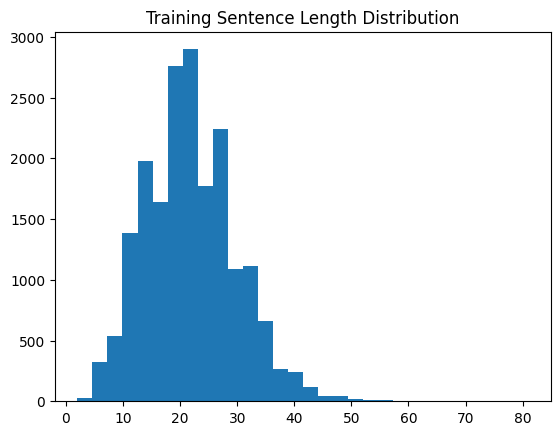

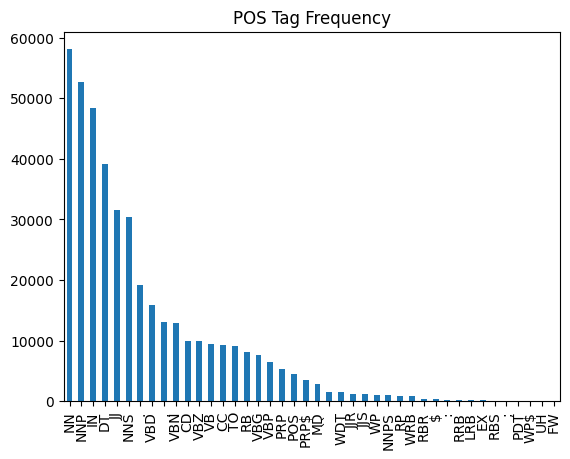

In [ ]:
# Training Sentence Length Distribution
plt.hist(train_lengths, bins=30)
plt.title('Training Sentence Length Distribution')
plt.show()

# POS Tag Frequency
tag_counts = pd.Series(all_pos).value_counts()
tag_counts.plot(kind='bar')
plt.title('POS Tag Frequency')
plt.show()

Building Model

In [ ]:
max_length = max(train_lengths)

def build_model(model_type, units=128, embedding_dim=100, learning_rate=0.001):
  model = Sequential()
  model.add(Embedding(word_vocab_size, embedding_dim, mask_zero=True))

  if model_type == 'rnn':
    model.add(SimpleRNN(units, return_sequences=True))
  elif model_type == 'gru':
    model.add(GRU(units, return_sequences=True))
  elif model_type == 'lstm':
    model.add(LSTM(units, return_sequences=True))
  elif model_type == 'bilstm':
    model.add(Bidirectional(LSTM(units, return_sequences=True)))

  model.add(Dense(num_tags, activation='softmax'))
  model.compile(
    loss=SparseCategoricalCrossentropy(ignore_class=-1),
    optimizer=Adam(learning_rate=learning_rate),
    metrics=['accuracy']
  )
  return model

Hyperparameter Tuning

In [ ]:
tuning_config = {
  'RNN': {
    'units_options': [max_length//2, max_length, max_length*2],
    'lr_options': [0.01, 0.001],
    'batch_options': [64, 128],
    'epoch_options': [30, 50]
  },
  'GRU': {
    'units_options': [max_length//2, max_length, max_length*2],
    'lr_options': [0.001, 0.0005],
    'batch_options': [64, 128],
    'epoch_options': [30, 50]
  },
  'LSTM': {
    'units_options': [max_length//2, max_length, max_length*2],
    'lr_options': [0.001, 0.0005],
    'batch_options': [64, 128],
    'epoch_options': [30, 50]
  },
  'BiLSTM': {
    'units_options': [max_length//2, max_length, max_length*2],
    'lr_options': [0.001, 0.0005],
    'batch_options': [64, 128],
    'epoch_options': [30, 50]
  }
}

Tuning Implementation

In [ ]:
best_models = {}
tuning_results = []

for model_name in tuning_config.keys():
  print(f"\n{'='*40}\nTuning {model_name}\n{'='*40}")
  config = tuning_config[model_name]

  best_val_f1 = 0
  best_params = None

  for units in config['units_options']:
    for lr in config['lr_options']:
      for batch_size in config['batch_options']:
        for epochs in config['epoch_options']:
          print(f"\nTesting {model_name}: units={units}, lr={lr}, batch={batch_size}, epochs={epochs}")

          model = build_model(
            model_type=model_name.lower(),
            units=units,
            learning_rate=lr
          )

          history = model.fit(
            X_train_split, y_train_split,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=[EarlyStopping(patience=3, restore_best_weights=True)],
            verbose=1
          )

          # Calculate validation metrics
          y_val_pred = model.predict(X_val, verbose=1)
          y_val_pred = np.argmax(y_val_pred, axis=2)

          true_labels, pred_labels = [], []
          for i in range(y_val.shape[0]):
            mask = y_val[i] != -1
            true_labels.extend(y_val[i][mask])
            pred_labels.extend(y_val_pred[i][mask])

          val_f1 = f1_score(true_labels, pred_labels, average='weighted', zero_division=0)
          val_acc = accuracy_score(true_labels, pred_labels)
          val_precision = precision_score(true_labels, pred_labels, average='weighted', zero_division=0)
          val_recall = recall_score(true_labels, pred_labels, average='weighted', zero_division=0)

          tuning_results.append({
            'Model': model_name,
            'Units': units,
            'LR': lr,
            'Batch': batch_size,
            'Epochs': epochs,
            'Val_Acc': val_acc,
            'Val_F1': val_f1,
            'Val_Precision': val_precision,
            'Val_Recall': val_recall
          })

          if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_models[model_name] = model
            best_params = {
              'units': units,
              'lr': lr,
              'batch_size': batch_size,
              'epochs': epochs
            }
            model.save(f'/content/drive/MyDrive/best_{model_name}.h5')
            pd.DataFrame(history.history).to_csv(
              f'/content/drive/MyDrive/best_{model_name}_history.csv',
              index=False
            )

  print(f"\nBest {model_name} params:", best_params)
  print(f"Best Validation F1: {best_val_f1:.4f}")


Tuning RNN

Testing RNN: units=40, lr=0.01, batch=64, epochs=30
Epoch 1/30
240/240 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - accuracy: 0.2091 - loss: 0.9124 - val_accuracy: 0.2541 - val_loss: 0.1648
Epoch 2/30
240/240 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.2620 - loss: 0.0986 - val_accuracy: 0.2545 - val_loss: 0.1626
Epoch 3/30
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.2622 - loss: 0.0723 - val_accuracy: 0.2548 - val_loss: 0.1672
Epoch 4/30
240/240 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.2642 - loss: 0.0600 - val_accuracy: 0.2543 - val_loss: 0.1810
Epoch 5/30
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.2653 - loss: 0.0521 - val_accuracy: 0.2544 - val_loss: 0.1915
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step



Testing RNN: units=40, lr=0.01, batch=64, epochs=50
Epoch 1/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.2080 - loss: 0.9231 - val_accuracy: 0.2545 - val_loss: 0.1645
Epoch 2/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.2626 - loss: 0.0987 - val_accuracy: 0.2547 - val_loss: 0.1617
Epoch 3/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.2639 - loss: 0.0731 - val_accuracy: 0.2548 - val_loss: 0.1673
Epoch 4/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.2652 - loss: 0.0584 - val_accuracy: 0.2543 - val_loss: 0.1805
Epoch 5/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.2662 - loss: 0.0507 - val_accuracy: 0.2543 - val_loss: 0.1896
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step



Testing RNN: units=40, lr=0.01, batch=128, epochs=30
Epoch 1/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.1904 - loss: 1.2126 - val_accuracy: 0.2539 - val_loss: 0.1705
Epoch 2/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.2607 - loss: 0.1049 - val_accuracy: 0.2546 - val_loss: 0.1591
Epoch 3/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.2628 - loss: 0.0758 - val_accuracy: 0.2549 - val_loss: 0.1635
Epoch 4/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.2652 - loss: 0.0594 - val_accuracy: 0.2544 - val_loss: 0.1729
Epoch 5/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.2661 - loss: 0.0508 - val_accuracy: 0.2544 - val_loss: 0.1855
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step

Testing RNN: units=40, lr=0.01, batch=128, epochs=50
Epoch 1/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - accuracy: 0.1915 - loss: 1.2364 - val_accuracy: 0.2539 - val_loss: 0.1689
Epoch 2/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.2612 - lo


Testing RNN: units=40, lr=0.001, batch=128, epochs=50
Epoch 1/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - accuracy: 0.0990 - loss: 2.8377 - val_accuracy: 0.2058 - val_loss: 1.0967
Epoch 2/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.2250 - loss: 0.8244 - val_accuracy: 0.2466 - val_loss: 0.3869
Epoch 3/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.2536 - loss: 0.3001 - val_accuracy: 0.2518 - val_loss: 0.2430
Epoch 4/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.2585 - loss: 0.1725 - val_accuracy: 0.2535 - val_loss: 0.1989
Epoch 5/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.2605 - loss: 0.1271 - val_accuracy: 0.2541 - val_loss: 0.1797
Epoch 6/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.2617 - loss: 0.1025 - val_accuracy: 0.2545 - val_loss: 0.1711
Epoch 7/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.2636 - loss: 0.0889 - val_accuracy: 0.2547 - val_loss: 0.1666
Epoch 8/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1


Testing RNN: units=81, lr=0.01, batch=64, epochs=30
Epoch 1/30
240/240 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - accuracy: 0.2109 - loss: 0.8507 - val_accuracy: 0.2540 - val_loss: 0.1640
Epoch 2/30
240/240 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.2613 - loss: 0.0934 - val_accuracy: 0.2548 - val_loss: 0.1590
Epoch 3/30
240/240 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.2644 - loss: 0.0682 - val_accuracy: 0.2550 - val_loss: 0.1624
Epoch 4/30
240/240 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.2644 - loss: 0.0556 - val_accuracy: 0.2548 - val_loss: 0.1746
Epoch 5/30
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.2662 - loss: 0.0465 - val_accuracy: 0.2546 - val_loss: 0.1871
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step



Testing RNN: units=81, lr=0.01, batch=64, epochs=50
Epoch 1/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.2107 - loss: 0.8384 - val_accuracy: 0.2546 - val_loss: 0.1598
Epoch 2/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.2617 - loss: 0.0902 - val_accuracy: 0.2551 - val_loss: 0.1537
Epoch 3/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.2642 - loss: 0.0663 - val_accuracy: 0.2549 - val_loss: 0.1640
Epoch 4/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.2664 - loss: 0.0534 - val_accuracy: 0.2549 - val_loss: 0.1764
Epoch 5/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.2666 - loss: 0.0460 - val_accuracy: 0.2544 - val_loss: 0.1936
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step



Testing RNN: units=81, lr=0.01, batch=128, epochs=30
Epoch 1/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - accuracy: 0.1969 - loss: 1.0675 - val_accuracy: 0.2546 - val_loss: 0.1616
Epoch 2/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.2613 - loss: 0.0971 - val_accuracy: 0.2550 - val_loss: 0.1549
Epoch 3/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.2627 - loss: 0.0662 - val_accuracy: 0.2550 - val_loss: 0.1602
Epoch 4/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.2649 - loss: 0.0534 - val_accuracy: 0.2546 - val_loss: 0.1777
Epoch 5/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.2658 - loss: 0.0445 - val_accuracy: 0.2550 - val_loss: 0.1785
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step

Testing RNN: units=81, lr=0.01, batch=128, epochs=50
Epoch 1/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.1944 - loss: 1.1175 - val_accuracy: 0.2540 - val_loss: 0.1644
Epoch 2/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.2612 - lo


Testing RNN: units=81, lr=0.001, batch=64, epochs=30
Epoch 1/30
240/240 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.1287 - loss: 2.1445 - val_accuracy: 0.2452 - val_loss: 0.3639
Epoch 2/30
240/240 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.2531 - loss: 0.2616 - val_accuracy: 0.2535 - val_loss: 0.1906
Epoch 3/30
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.2606 - loss: 0.1241 - val_accuracy: 0.2547 - val_loss: 0.1641
Epoch 4/30
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.2619 - loss: 0.0875 - val_accuracy: 0.2550 - val_loss: 0.1567
Epoch 5/30
240/240 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.2637 - loss: 0.0708 - val_accuracy: 0.2551 - val_loss: 0.1590
Epoch 6/30
240/240 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.2647 - loss: 0.0589 - val_accuracy: 0.2547 - val_loss: 0.1663
Epoch 7/30
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.2663 - loss: 0.0496 - val_accuracy: 0.2547 - val_loss: 0.1706
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step




Testing GRU: units=40, lr=0.001, batch=64, epochs=50
Epoch 1/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.1326 - loss: 2.3633 - val_accuracy: 0.2426 - val_loss: 0.4358
Epoch 2/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.2513 - loss: 0.3223 - val_accuracy: 0.2521 - val_loss: 0.2204
Epoch 3/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.2591 - loss: 0.1547 - val_accuracy: 0.2536 - val_loss: 0.1793
Epoch 4/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.2608 - loss: 0.1096 - val_accuracy: 0.2543 - val_loss: 0.1637
Epoch 5/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.2619 - loss: 0.0905 - val_accuracy: 0.2546 - val_loss: 0.1579
Epoch 6/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.2634 - loss: 0.0774 - val_accuracy: 0.2550 - val_loss: 0.1555
Epoch 7/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.2635 - loss: 0.0701 - val_accuracy: 0.2550 - val_loss: 0.1564
Epoch 8/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/


Testing GRU: units=40, lr=0.001, batch=128, epochs=50
Epoch 1/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.1199 - loss: 2.8708 - val_accuracy: 0.2174 - val_loss: 0.9240
Epoch 2/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.2329 - loss: 0.6883 - val_accuracy: 0.2471 - val_loss: 0.3479
Epoch 3/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.2551 - loss: 0.2688 - val_accuracy: 0.2520 - val_loss: 0.2332
Epoch 4/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.2593 - loss: 0.1702 - val_accuracy: 0.2532 - val_loss: 0.1948
Epoch 5/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.2597 - loss: 0.1269 - val_accuracy: 0.2539 - val_loss: 0.1766
Epoch 6/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.2617 - loss: 0.1063 - val_accuracy: 0.2542 - val_loss: 0.1679
Epoch 7/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.2629 - loss: 0.0950 - val_accuracy: 0.2546 - val_loss: 0.1627
Epoch 8/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s


Testing GRU: units=40, lr=0.0005, batch=128, epochs=30
Epoch 1/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.0903 - loss: 3.2475 - val_accuracy: 0.1544 - val_loss: 1.7402
Epoch 2/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.1732 - loss: 1.4716 - val_accuracy: 0.2199 - val_loss: 0.8690
Epoch 3/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.2312 - loss: 0.7290 - val_accuracy: 0.2423 - val_loss: 0.4851
Epoch 4/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.2494 - loss: 0.4074 - val_accuracy: 0.2484 - val_loss: 0.3370
Epoch 5/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.2542 - loss: 0.2763 - val_accuracy: 0.2508 - val_loss: 0.2694
Epoch 6/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.2584 - loss: 0.2086 - val_accuracy: 0.2519 - val_loss: 0.2326
Epoch 7/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.2586 - loss: 0.1694 - val_accuracy: 0.2528 - val_loss: 0.2102
Epoch 8/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 2


Testing GRU: units=81, lr=0.001, batch=64, epochs=50
Epoch 1/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.1444 - loss: 2.1375 - val_accuracy: 0.2467 - val_loss: 0.3245
Epoch 2/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.2544 - loss: 0.2422 - val_accuracy: 0.2534 - val_loss: 0.1863
Epoch 3/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.2596 - loss: 0.1251 - val_accuracy: 0.2546 - val_loss: 0.1603
Epoch 4/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.2623 - loss: 0.0929 - val_accuracy: 0.2551 - val_loss: 0.1529
Epoch 5/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.2628 - loss: 0.0775 - val_accuracy: 0.2553 - val_loss: 0.1506
Epoch 6/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.2611 - loss: 0.0684 - val_accuracy: 0.2555 - val_loss: 0.1511
Epoch 7/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.2643 - loss: 0.0617 - val_accuracy: 0.2555 - val_loss: 0.1519
Epoch 8/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms


Testing LSTM: units=40, lr=0.001, batch=64, epochs=50
Epoch 1/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.1022 - loss: 2.6907 - val_accuracy: 0.2268 - val_loss: 0.7958
Epoch 2/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.2400 - loss: 0.5753 - val_accuracy: 0.2499 - val_loss: 0.3027
Epoch 3/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.2567 - loss: 0.2211 - val_accuracy: 0.2532 - val_loss: 0.2161
Epoch 4/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.2594 - loss: 0.1436 - val_accuracy: 0.2540 - val_loss: 0.1871
Epoch 5/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.2606 - loss: 0.1113 - val_accuracy: 0.2545 - val_loss: 0.1725
Epoch 6/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.2629 - loss: 0.0939 - val_accuracy: 0.2547 - val_loss: 0.1665
Epoch 7/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.2632 - loss: 0.0814 - val_accuracy: 0.2549 - val_loss: 0.1643
Epoch 8/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 3s 1


Testing LSTM: units=40, lr=0.001, batch=128, epochs=30
Epoch 1/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.0828 - loss: 3.0968 - val_accuracy: 0.1707 - val_loss: 1.5260
Epoch 2/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.1994 - loss: 1.2185 - val_accuracy: 0.2385 - val_loss: 0.5865
Epoch 3/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.2476 - loss: 0.4650 - val_accuracy: 0.2495 - val_loss: 0.3299
Epoch 4/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.2571 - loss: 0.2532 - val_accuracy: 0.2521 - val_loss: 0.2488
Epoch 5/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.2598 - loss: 0.1784 - val_accuracy: 0.2531 - val_loss: 0.2137
Epoch 6/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.2611 - loss: 0.1412 - val_accuracy: 0.2537 - val_loss: 0.1942
Epoch 7/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.2624 - loss: 0.1178 - val_accuracy: 0.2540 - val_loss: 0.1826
Epoch 8/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 1


Testing LSTM: units=40, lr=0.0005, batch=64, epochs=50
Epoch 1/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.0726 - loss: 3.1302 - val_accuracy: 0.1548 - val_loss: 1.6848
Epoch 2/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.1821 - loss: 1.3958 - val_accuracy: 0.2277 - val_loss: 0.7613
Epoch 3/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.2384 - loss: 0.6202 - val_accuracy: 0.2457 - val_loss: 0.4116
Epoch 4/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.2510 - loss: 0.3296 - val_accuracy: 0.2508 - val_loss: 0.2898
Epoch 5/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.2578 - loss: 0.2164 - val_accuracy: 0.2521 - val_loss: 0.2377
Epoch 6/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.2600 - loss: 0.1685 - val_accuracy: 0.2529 - val_loss: 0.2099
Epoch 7/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.2596 - loss: 0.1374 - val_accuracy: 0.2535 - val_loss: 0.1937
Epoch 8/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 1


Testing LSTM: units=81, lr=0.001, batch=64, epochs=50
Epoch 1/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.1068 - loss: 2.5298 - val_accuracy: 0.2369 - val_loss: 0.5317
Epoch 2/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.2475 - loss: 0.3784 - val_accuracy: 0.2525 - val_loss: 0.2280
Epoch 3/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.2598 - loss: 0.1571 - val_accuracy: 0.2542 - val_loss: 0.1785
Epoch 4/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.2616 - loss: 0.1071 - val_accuracy: 0.2547 - val_loss: 0.1638
Epoch 5/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.2627 - loss: 0.0859 - val_accuracy: 0.2550 - val_loss: 0.1593
Epoch 6/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.2639 - loss: 0.0735 - val_accuracy: 0.2553 - val_loss: 0.1564
Epoch 7/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.2636 - loss: 0.0650 - val_accuracy: 0.2553 - val_loss: 0.1587
Epoch 8/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s


Testing LSTM: units=162, lr=0.0005, batch=64, epochs=30
Epoch 1/30
240/240 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.0818 - loss: 2.8257 - val_accuracy: 0.1898 - val_loss: 1.1568
Epoch 2/30
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.2156 - loss: 0.8550 - val_accuracy: 0.2454 - val_loss: 0.3740
Epoch 3/30
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.2539 - loss: 0.2862 - val_accuracy: 0.2521 - val_loss: 0.2312
Epoch 4/30
240/240 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.2608 - loss: 0.1636 - val_accuracy: 0.2536 - val_loss: 0.1887
Epoch 5/30
240/240 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.2606 - loss: 0.1204 - val_accuracy: 0.2545 - val_loss: 0.1702
Epoch 6/30
240/240 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.2627 - loss: 0.0981 - val_accuracy: 0.2550 - val_loss: 0.1615
Epoch 7/30
240/240 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.2630 - loss: 0.0839 - val_accuracy: 0.2552 - val_loss: 0.1584
Epoch 8/30
240/240 ━━━━━━━━━━━━━━━━━━━━ 


Testing BiLSTM: units=40, lr=0.001, batch=64, epochs=50
Epoch 1/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.1047 - loss: 2.4948 - val_accuracy: 0.2392 - val_loss: 0.4850
Epoch 2/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.2493 - loss: 0.3403 - val_accuracy: 0.2545 - val_loss: 0.1969
Epoch 3/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.2611 - loss: 0.1335 - val_accuracy: 0.2566 - val_loss: 0.1511
Epoch 4/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.2643 - loss: 0.0845 - val_accuracy: 0.2575 - val_loss: 0.1364
Epoch 5/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.2652 - loss: 0.0635 - val_accuracy: 0.2579 - val_loss: 0.1310
Epoch 6/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.2669 - loss: 0.0502 - val_accuracy: 0.2579 - val_loss: 0.1292
Epoch 7/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.2665 - loss: 0.0408 - val_accuracy: 0.2580 - val_loss: 0.1311
Epoch 8/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 


Testing BiLSTM: units=40, lr=0.001, batch=128, epochs=50
Epoch 1/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.0882 - loss: 2.9263 - val_accuracy: 0.1935 - val_loss: 1.1596
Epoch 2/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.2192 - loss: 0.8457 - val_accuracy: 0.2478 - val_loss: 0.3488
Epoch 3/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.2558 - loss: 0.2614 - val_accuracy: 0.2545 - val_loss: 0.2068
Epoch 4/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.2620 - loss: 0.1406 - val_accuracy: 0.2565 - val_loss: 0.1632
Epoch 5/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.2614 - loss: 0.0975 - val_accuracy: 0.2573 - val_loss: 0.1453
Epoch 6/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.2646 - loss: 0.0749 - val_accuracy: 0.2578 - val_loss: 0.1358
Epoch 7/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.2661 - loss: 0.0609 - val_accuracy: 0.2579 - val_loss: 0.1314
Epoch 8/50
120/120 ━━━━━━━━━━━━━━━━━━━━


Testing BiLSTM: units=40, lr=0.0005, batch=128, epochs=30
Epoch 1/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.0687 - loss: 3.2734 - val_accuracy: 0.1293 - val_loss: 1.9816
Epoch 2/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.1503 - loss: 1.7047 - val_accuracy: 0.2095 - val_loss: 0.9986
Epoch 3/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.2235 - loss: 0.8184 - val_accuracy: 0.2409 - val_loss: 0.4890
Epoch 4/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.2481 - loss: 0.4040 - val_accuracy: 0.2496 - val_loss: 0.3083
Epoch 5/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.2562 - loss: 0.2472 - val_accuracy: 0.2535 - val_loss: 0.2312
Epoch 6/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.2600 - loss: 0.1741 - val_accuracy: 0.2552 - val_loss: 0.1927
Epoch 7/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.2608 - loss: 0.1347 - val_accuracy: 0.2561 - val_loss: 0.1709
Epoch 8/30
120/120 ━━━━━━━━━━━━━━━━━━━


Testing BiLSTM: units=81, lr=0.001, batch=64, epochs=50
Epoch 1/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.1107 - loss: 2.3370 - val_accuracy: 0.2466 - val_loss: 0.3261
Epoch 2/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.2546 - loss: 0.2282 - val_accuracy: 0.2565 - val_loss: 0.1536
Epoch 3/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.2640 - loss: 0.0957 - val_accuracy: 0.2579 - val_loss: 0.1281
Epoch 4/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.2648 - loss: 0.0638 - val_accuracy: 0.2584 - val_loss: 0.1213
Epoch 5/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.2663 - loss: 0.0482 - val_accuracy: 0.2585 - val_loss: 0.1202
Epoch 6/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.2666 - loss: 0.0376 - val_accuracy: 0.2585 - val_loss: 0.1235
Epoch 7/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.2689 - loss: 0.0304 - val_accuracy: 0.2586 - val_loss: 0.1286
Epoch 8/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 


Testing BiLSTM: units=81, lr=0.001, batch=128, epochs=30
Epoch 1/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.0858 - loss: 2.7974 - val_accuracy: 0.2149 - val_loss: 0.8469
Epoch 2/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.2344 - loss: 0.5777 - val_accuracy: 0.2520 - val_loss: 0.2435
Epoch 3/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.2585 - loss: 0.1768 - val_accuracy: 0.2562 - val_loss: 0.1627
Epoch 4/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.2621 - loss: 0.1053 - val_accuracy: 0.2572 - val_loss: 0.1385
Epoch 5/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.2650 - loss: 0.0761 - val_accuracy: 0.2579 - val_loss: 0.1286
Epoch 6/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.2650 - loss: 0.0613 - val_accuracy: 0.2581 - val_loss: 0.1252
Epoch 7/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.2663 - loss: 0.0483 - val_accuracy: 0.2581 - val_loss: 0.1251
Epoch 8/30
120/120 ━━━━━━━━━━━━━━━━━━━━

Model Evaluation

In [ ]:
all_classes = label_encoder.classes_
all_labels = label_encoder.transform(all_classes)

final_metrics = []
for model_name, model in best_models.items():
  y_pred = model.predict(X_test)
  y_pred = np.argmax(y_pred, axis=2)

  true_labels, pred_labels = [], []
  predictions = []
  for i in range(y_test.shape[0]):
    mask = y_test[i] != -1
    true_labels.extend(y_test[i][mask])
    pred_labels.extend(y_pred[i][mask])
    predictions.append(y_pred[i])

  final_metrics.append({
    'Model': model_name,
    'Accuracy': accuracy_score(true_labels, pred_labels),
    'Precision': precision_score(true_labels, pred_labels, average='weighted', zero_division=0),
    'Recall': recall_score(true_labels, pred_labels, average='weighted', zero_division=0),
    'F1': f1_score(true_labels, pred_labels, average='weighted', zero_division=0),
    'Confusion_Matrix': confusion_matrix(true_labels, pred_labels, labels=all_labels),
    'Classification_Report': classification_report(
      true_labels, pred_labels,
      labels=all_labels,
      target_names=all_classes,
      zero_division=0
    ),
    'true_labels': true_labels,
    'pred_labels': pred_labels,
    'predictions': predictions
  })

150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [ ]:
print("\n\n" + "="*60)
print(" Comprehensive Model Evaluation Reports")
print("="*60 + "\n")

for metrics in final_metrics:
  print(f"\n{'='*40}\n{metrics['Model']} Performance\n{'='*40}")
  print(f"Test Accuracy: {metrics['Accuracy']:.4f}")
  print(f"Weighted F1-Score: {metrics['F1']:.4f}")
  print("\nDetailed Classification Report:")
  print(metrics['Classification_Report'])



 Comprehensive Model Evaluation Reports


RNN Performance
Test Accuracy: 0.9512
Weighted F1-Score: 0.9512

Detailed Classification Report:
              precision    recall  f1-score   support

           $       1.00      1.00      1.00       113
           ,       1.00      1.00      1.00      3238
           .       1.00      1.00      1.00      4779
           :       0.67      0.65      0.66        89
           ;       1.00      1.00      1.00        20
          CC       1.00      1.00      1.00      2403
          CD       0.99      0.95      0.97      2476
          DT       1.00      1.00      1.00      9928
          EX       0.94      1.00      0.97        61
          FW       0.00      0.00      0.00         0
          IN       0.99      0.98      0.99     12229
          JJ       0.90      0.88      0.89      7783
         JJR       0.93      0.86      0.90       278
         JJS       0.94      0.96      0.95       315
         LRB       1.00      0.97      0.99     

Visualization

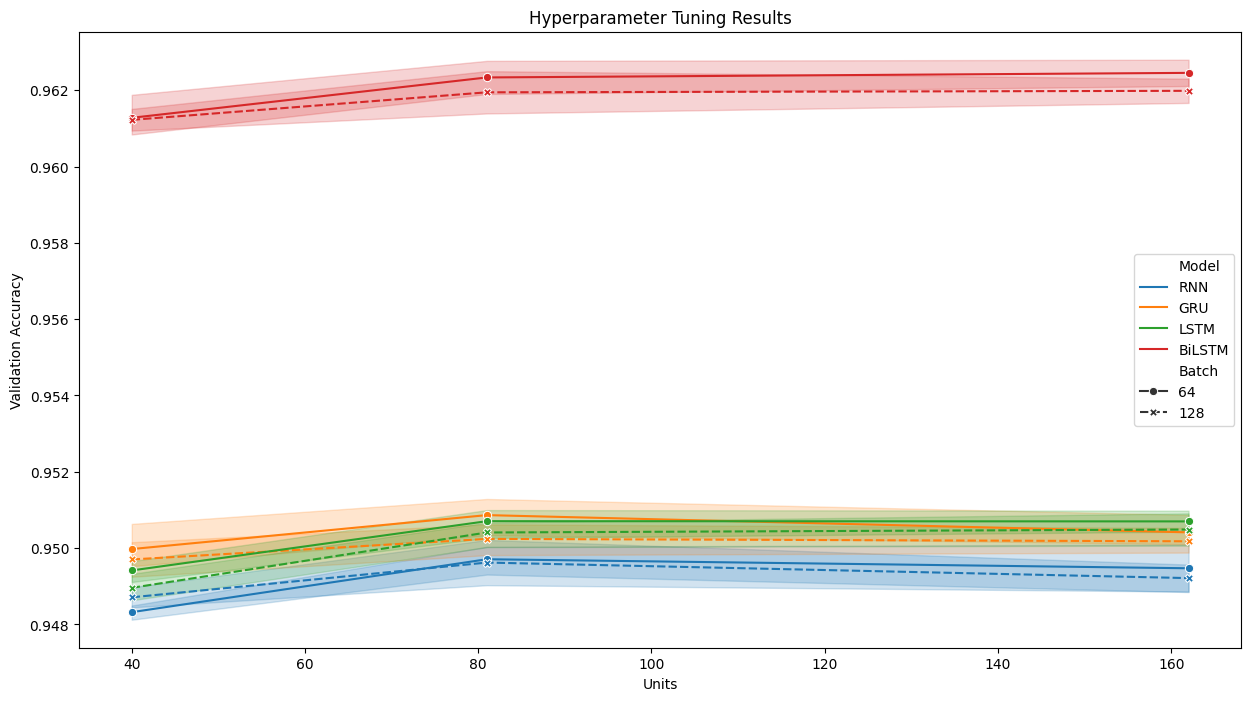

In [ ]:
# 1. Tuning Results Visualization
tuning_df = pd.DataFrame(tuning_results)
plt.figure(figsize=(15, 8))
sns.lineplot(
  data=tuning_df,
  x='Units',
  y='Val_Acc',
  hue='Model',
  style='Batch',
  markers=True
)
plt.title('Hyperparameter Tuning Results')
plt.ylabel('Validation Accuracy')
plt.show()

In [ ]:
# 2. Final Performance Comparison
print("\nFinal Model Comparison:")
results_df = pd.DataFrame(final_metrics).drop(columns=[
  'Confusion_Matrix', 'Classification_Report',
  'true_labels', 'pred_labels', 'predictions'
])
display(results_df.style.background_gradient(
  cmap='Blues',
  subset=['Accuracy', 'F1', 'Precision', 'Recall']
))


Final Model Comparison:


,Model,Accuracy,Precision,Recall,F1
0,RNN,0.951212,0.951500,0.951212,0.951193
1,GRU,0.952136,0.952087,0.952136,0.951992
2,LSTM,0.952564,0.952836,0.952564,0.952587
3,BiLSTM,0.964376,0.964711,0.964376,0.964409


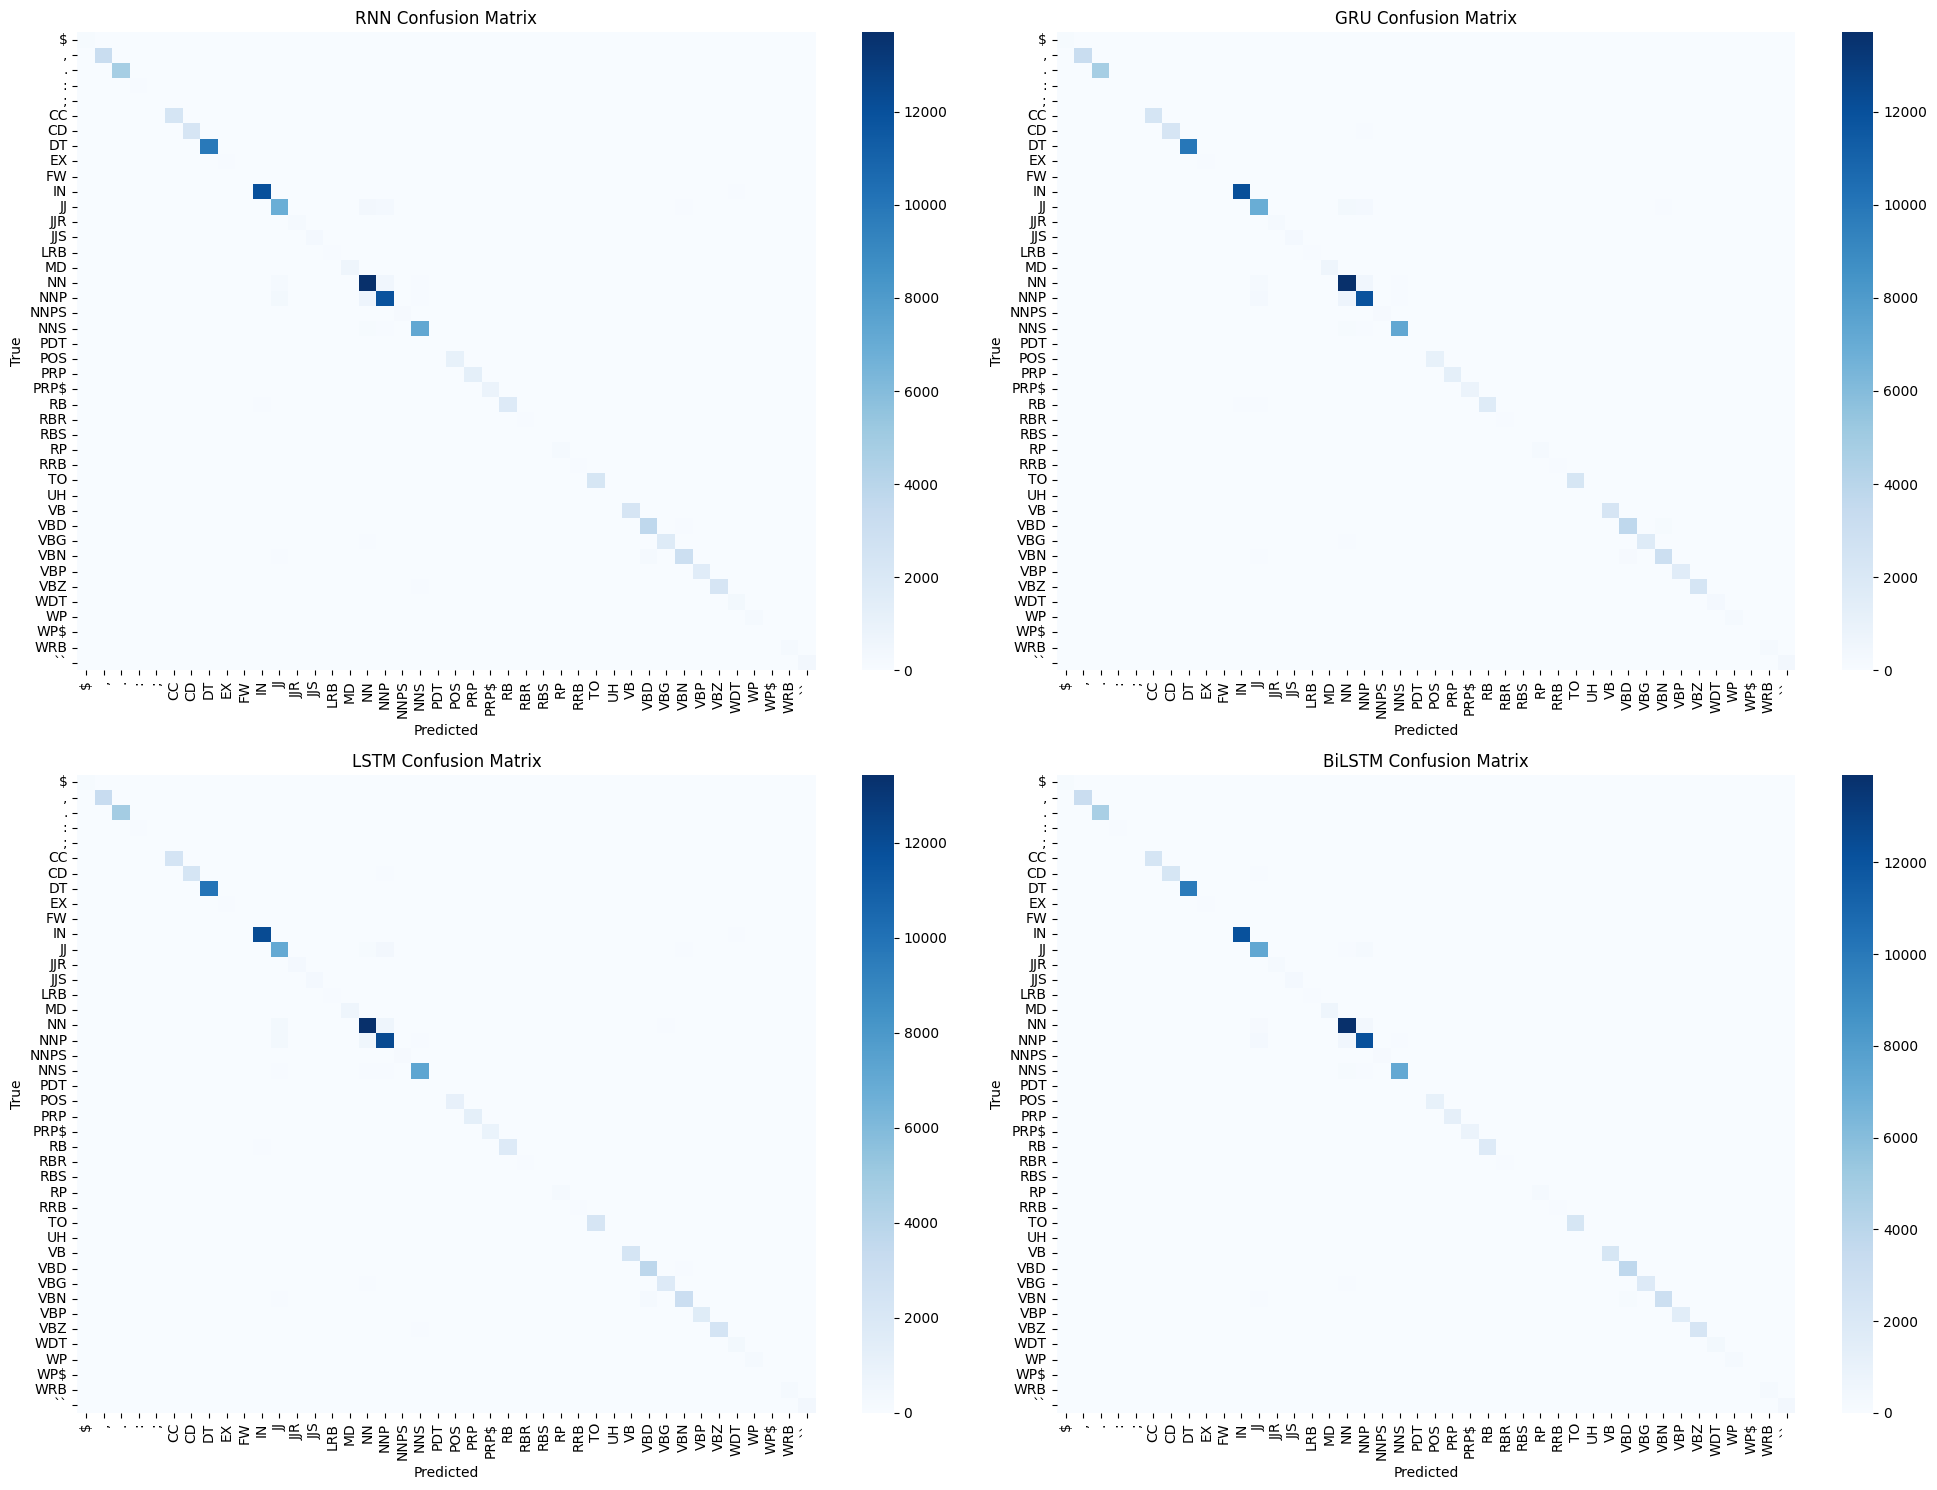

In [ ]:
# 3. Confusion Matrices
plt.figure(figsize=(20, 15))
for idx, metrics in enumerate(final_metrics, 1):
  plt.subplot(2, 2, idx)
  sns.heatmap(metrics['Confusion_Matrix'],
            annot=False,
            cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
  plt.title(f'{metrics["Model"]} Confusion Matrix')
  plt.xlabel('Predicted')
  plt.ylabel('True')
plt.tight_layout()
plt.show()

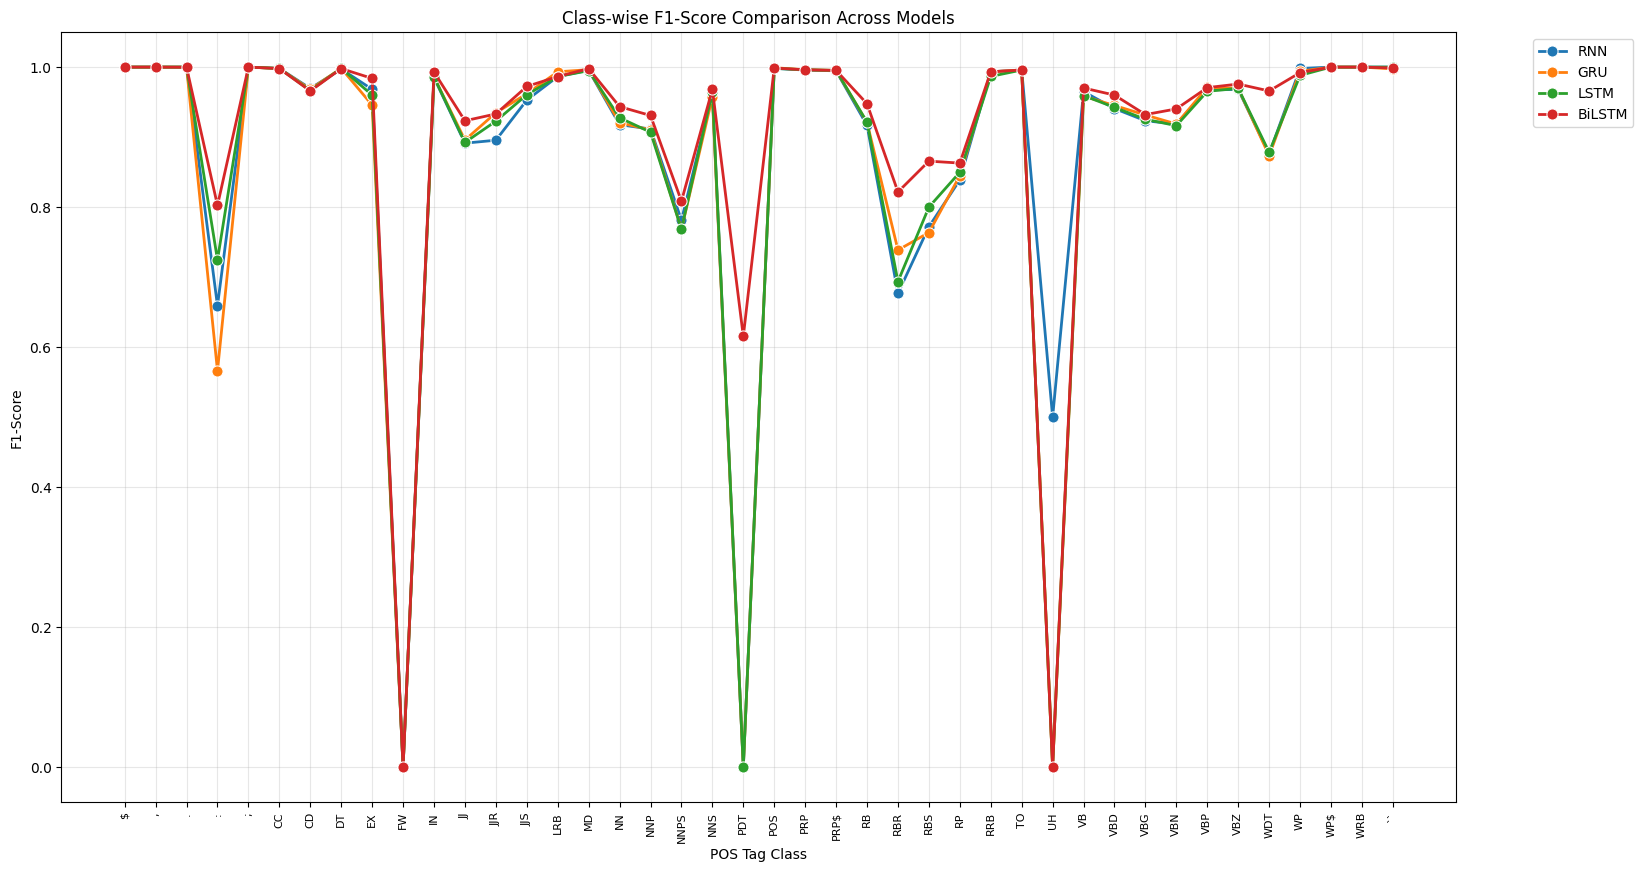

In [ ]:
# 4. Class-wise Performance Comparison
plt.figure(figsize=(18, 10))
class_performance = []

for metrics in final_metrics:
  # Get model-specific predictions
  model_true = []
  model_pred = []
  for i in range(y_test.shape[0]):
    mask = y_test[i] != -1
    model_true.extend(y_test[i][mask])
    model_pred.extend(metrics['predictions'][i][mask])

  # Generate report for this model's predictions
  report_dict = classification_report(
    model_true, model_pred,
    labels=all_labels,
    target_names=all_classes,
    output_dict=True,
    zero_division=0
  )

  # Collect class performance data
  for cls in all_classes:
    class_performance.append({
      'Model': metrics['Model'],
      'Class': cls,
      'F1-Score': report_dict[cls]['f1-score']
    })

class_df = pd.DataFrame(class_performance)

sns.lineplot(
  data=class_df,
  x='Class',
  y='F1-Score',
  hue='Model',
  marker='o',
  markersize=8,
  linewidth=2
)

plt.title('Class-wise F1-Score Comparison Across Models')
plt.ylabel('F1-Score')
plt.xlabel('POS Tag Class')
plt.xticks(rotation=90, fontsize=8)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.show()

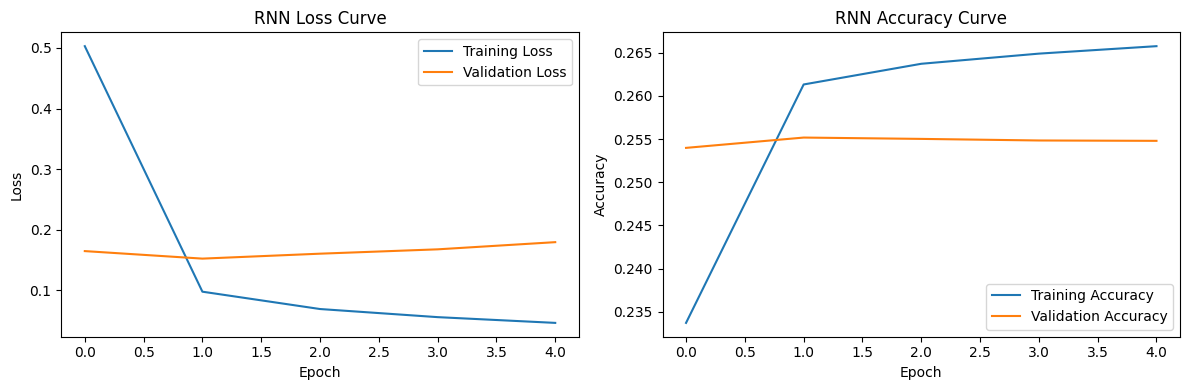

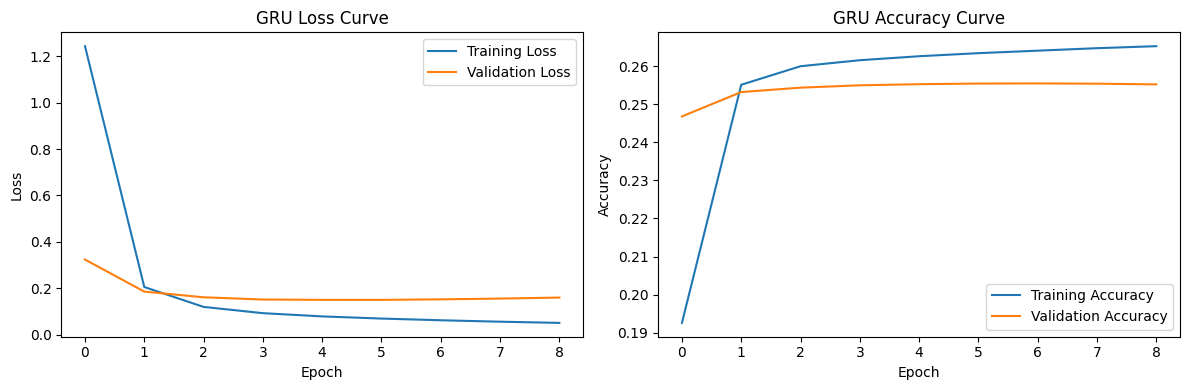

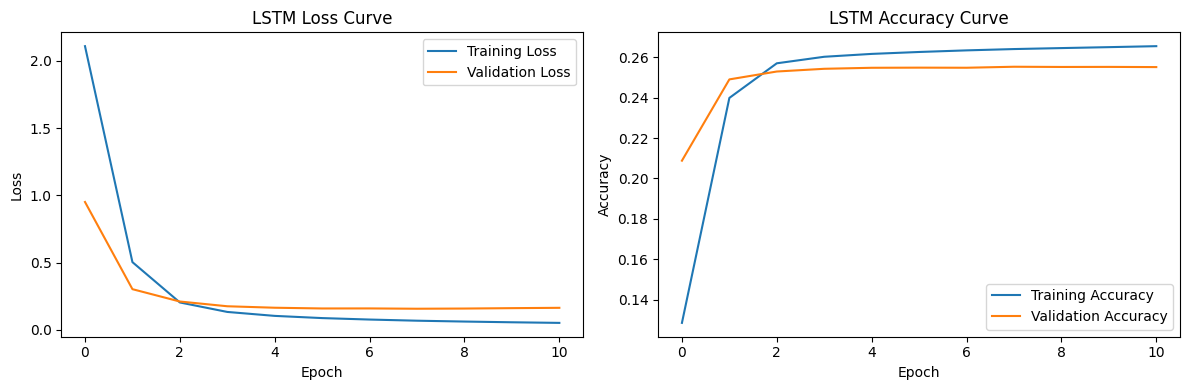

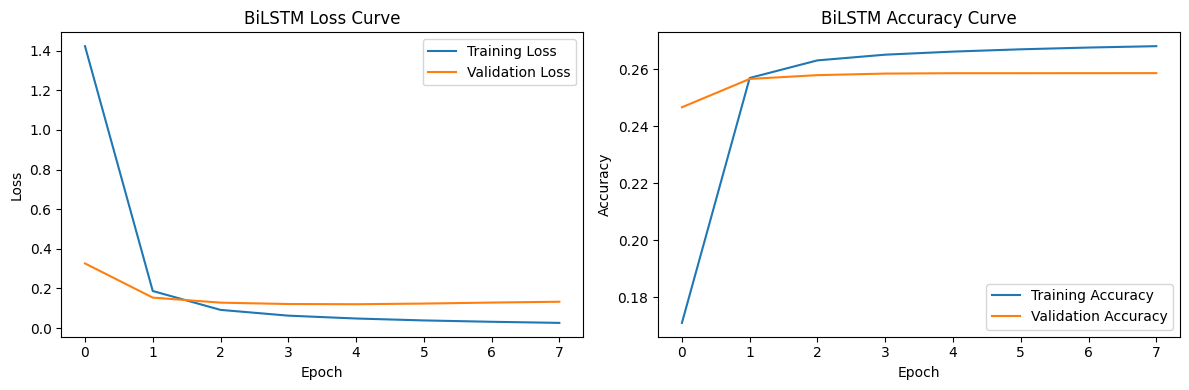

In [ ]:
# 5. Learning Curve Visualization
def plot_learning_curves(model_name):
  history = pd.read_csv(f'/content/drive/MyDrive/best_{model_name}_history.csv')

  plt.figure(figsize=(12, 4))

  plt.subplot(1, 2, 1)
  plt.plot(history['loss'], label='Training Loss')
  plt.plot(history['val_loss'], label='Validation Loss')
  plt.title(f'{model_name} Loss Curve')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(history['accuracy'], label='Training Accuracy')
  plt.plot(history['val_accuracy'], label='Validation Accuracy')
  plt.title(f'{model_name} Accuracy Curve')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.tight_layout()
  plt.show()

for model_name in best_models.keys():
  plot_learning_curves(model_name)